# **FACIAL EXPRESSION RECOGNITION**

# 0. Intro.

## STRUCTURE OF THE REPORT:
- This report consists of 2 parts;
  - **Part 1 (not for run)**: Split the data and feature extraction for fine-tuning;
  - **Part 2 (run it)**: Fine-Tuning with unfreezing of several layers and test-drive;

## INTRODUCTION:
- **The problem**: Facial expression -  a powerful mean of conveying emotions. The task is to create a model that can recognize emotions and implement it in the real-time video.
-**Why this is important**: The solution to such a problem has a variety of applications in different realms such as healthcare (treating autistic patients, mental-health monitoring) or customer service (analyzing the satisfaction level of customers).

## DATASET DESCRIPTION:
- **The link**: https://www.kaggle.com/datasets/sudarshanvaidya/random-images-for-face-emotion-recognition/data
- **Why we utilized it**: this dataset contains 224*224 images, which matches the size of ImageNet photos that were used for training of ResNet originally;
- **Content**: 7 emotions: [Anger, Fear, Happy, Neutral, Sad, Disgust, Surprise], 2921 images, 224*224 size;
- **Details**: publicly available dataset;
- **Enrichment**: I has created videos with my own face (and my friends' ones) showing different emotions under different angles, light sources, and backgrounds. Then, using OpenCV, I extracted frames from these videos, preprocessed them (grayscaling, normalization, and resizing), and enriched the original dataset with these new images.


## MODEL DESCRIPTION:
- **What model architecture I picked and why**: ResNet-50, because it's a good trade-off between computational load and accuracy, nowadays;
- **Type of model**: CNN with a FC classifier on the top;
- **The model structure**: It has 50 layers which are composed into: [zero padding, CONV, Batch Norm, ReLU, Max Pool, BottleNeck 1, BottleNeck 2, BottleNeck 3, BottleNeck 4, Avg Pool, Flattering, FC Classifier].
  - A bottleneck - a block of layers that contains a 'skip connection', convolutional layers, Batch Normalization layers, and ReLU;
  - A bottleneck always contains these three convolutional layers: a 1x1 convolution, a 3x3 convolution, and another 1x1 convolution. The 1x1 convolutions are responsible for reducing and then increasing (restoring) dimensions, leaving the 3x3 convolution a bottleneck with smaller input/output dimensions;
  - Approximate number of parameters in this model is ~ 25.6 million.

# 1. Split the data. (No need to run this code. This code is just for history)

## Initially I had 'before_splitting' folder.
- This folder already contained not only Kaggle dataset, but also my own photos that I made by making videos with different emotions/lighting conditions/angles and extracting/preprocessing frames out of these videos;
- After trials and errors, I found out that two exact emotions are always confusing since they look alike - fear and surprise;
- I have dropped two classes ('surprise' and 'disgust') and manually dropped obviously bad photos from all emotions in this folder (to roughly balance the number of images in each folder);
- Below is the way how I split this folder:
  - Splitting was conducted on a local machine, not Google Collab;
  - Splitting ratio: 80% for training, 20% for testing;
  - I used stratification to make sure there was no significant imbalance;
  - I used random splitting setting the random seed to make sure we could repeat it again.

In [ ]:
# import os
# import random
# import shutil
# from sklearn.model_selection import train_test_split

In [ ]:
# # Path to the directory containing the 5 folders of images
# source_dir = 'before_splitting'

# # Paths for the train and test directories
# train_dir = 'train'
# test_dir = 'test'

# # Create train and test directories if they don't exist
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)


In [ ]:
# # List all subdirectories in the source directory
# #folders = [f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))]

# folders = [
#     'Anger',
#     'Fear',
#     'Happy',
#     'Neutral',
#     'Sad',
#     'disgust'
# ]

# for folder in folders:
#     # List all files in the folder
#     files = [f for f in os.listdir(os.path.join(source_dir, folder)) if os.path.isfile(os.path.join(source_dir, folder, f))]

#     # Create a list of labels matching the file list
#     labels = [folder] * len(files)  # Each file in the folder has the same label as the folder name

#     # Split files into train and test sets with stratification
#     train_files, test_files = train_test_split(files, test_size=0.2, random_state=42, stratify=labels)

#     # Function to copy files to a new location
#     def copy_files(files, dest_folder):
#         os.makedirs(dest_folder, exist_ok=True)  # Create destination folder if it doesn't exist
#         for file in files:
#             shutil.copy(os.path.join(source_dir, folder, file), os.path.join(dest_folder, file))

#     # Copy train and test files to their respective directories
#     train_folder = os.path.join(train_dir, folder)
#     test_folder = os.path.join(test_dir, folder)

#     copy_files(train_files, train_folder)
#     copy_files(test_files, test_folder)


## ↑ This is how we got two folders: "train" and "test".
- both of them contain 6 classes;
- for all coding parts designed for 5 classes, we use exactly the same folders but without 'disgust' emotion in them.

# 2. Feature extraction. (No need to run this code. This code is just for history)
- Ususally, for transfer learning, it's better to start with feature extraction so one can do first adjustments of weights of FL classifier and proceed then with deeper layers;
  - I conducted feature maps extraction using the pre-trained ResNet-50 model without changing anything in it. This is how I got a feature map out of my dataset;
  - After that, using the feature maps I got, I updated and tuned the FC classifier;
  -I saved the model with adjusted FC classifier;
- In the future, after trials and errors with, I found out that using the state dictionary with tuned FC (which we got after the feature extraction) didn't improve the performance of fine-tuning while gradual unfreezing compared to the scenario when I use non-udjusted FC classifier, so **I decided not to use feature extraction**.

### Step 1: Load ResNet-50 Pre-trained Model

In [ ]:
# import torch
# from torchvision import models, datasets, transforms
# from torch.utils.data import DataLoader

# # Load pre-trained ResNet-50
# model = models.resnet50(pretrained=True)

# # Remove the final fully connected layer (classifier)
# model = torch.nn.Sequential(*(list(model.children())[:-1]))

# # Set the model to evaluation mode
# model.eval()

# # If using GPU
# # model.cuda()


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


### Step 2: Prepare the Data

In [ ]:
# # Augmentation and normalization for training
# train_transform = transforms.Compose([
#     # transforms.RandomResizedCrop(224),  # Crop the images to 224x224 pixels
#     transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),  # Random scaling/zooming
#     transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
#     transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change the brightness, contrast, saturation, and hue
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# # Normalization for testing, without augmentation
# test_transform = transforms.Compose([
#     # transforms.Resize(256),
#     # transforms.CenterCrop(224),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])
# # Apply these transforms respectively while loading your training and testing datasets



# train_dataset = datasets.ImageFolder(root='path/to/train',
#                                      transform=train_transform,
#                                     )
# test_dataset = datasets.ImageFolder(root='path/to/test',
#                                     transform=test_transform,
#                                    )
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)  # Adjust batch_size based on performance
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # Adjust batch_size based on performance

### Step 3: Extract Features

In [ ]:
# def extract_features(loader):
#     features = []
#     labels = []

#     with torch.no_grad():  # No need to compute gradients
#         for inputs, label_batch in loader:
#             # If using GPU
#             # inputs = inputs.cuda()
#             output = model(inputs)

#             # Reshape the output and convert to numpy array
#             output = output.view(output.size(0), -1).cpu().numpy()

#             features.extend(output)
#             labels.extend(label_batch.numpy())

#     return features, labels

# train_features, train_labels = extract_features(train_loader)
# test_features, test_labels = extract_features(test_loader)


### Step 4: Save the feature maps

In [ ]:
# #Step 1: Import the Pickle Module
# import pickle

In [ ]:
# #Step 2: Save the Feature Vectors and Labels to Disk

# # Saving train features and labels
# with open('train_features.pkl', 'wb') as f:
#     pickle.dump(train_features, f)

# with open('train_labels.pkl', 'wb') as f:
#     pickle.dump(train_labels, f)

# # Saving test features and labels
# with open('test_features.pkl', 'wb') as f:
#     pickle.dump(test_features, f)

# with open('test_labels.pkl', 'wb') as f:
#     pickle.dump(test_labels, f)


### Step 5: See how well ResNet-50 classify feature maps we got (rough examination - without training)

In [ ]:
# import pickle

# #Loading the Feature Vectors and Labels from Disk
# #When you need to use these stored features and labels, you can load them back into Python using pickle.load().

# # Loading train features and labels





# with open('train_features.pkl', 'rb') as f:
#     train_features = pickle.load(f)

# with open('train_labels.pkl', 'rb') as f:
#     train_labels = pickle.load(f)

# # Loading test features and labels
# with open('test_features.pkl', 'rb') as f:
#     test_features = pickle.load(f)

# with open('test_labels.pkl', 'rb') as f:
#     test_labels = pickle.load(f)

Step 5.1: Load and Modify ResNet-50
First, load the ResNet-50 model pre-trained on ImageNet, freeze its parameters, and replace the final fully connected layer with a new one tailored to your number of classes.

In [ ]:
# from torchvision import models
# import torch.nn as nn

# # Load pre-trained ResNet-50
# model = models.resnet50(pretrained=True)

# # Freeze all layers in the model
# for param in model.parameters():
#     param.requires_grad = False

# # Replace the final fully connected layer
# # Assume num_classes is the number of your dataset classes
# num_classes = 6 #len(train_dataset.classes)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)

# # If using a GPU
# # model = model.cuda()

Step 5.2: Prepare Datasets
Assuming train_features, train_labels, test_features, and test_labels are already loaded in your environment, you should wrap them in a TensorDataset and create DataLoaders for them. This is necessary to easily iterate over the data during training and testing.

In [ ]:
# from torch.utils.data import TensorDataset, DataLoader
# import torch

# # Convert arrays into tensors
# train_feat = torch.tensor(train_features).float()
# train_lbls = torch.tensor(train_labels).long()  # Make sure labels are long type
# test_feat = torch.tensor(test_features).float()
# test_lbls = torch.tensor(test_labels).long()

# # Create TensorDatasets
# train_dataset = TensorDataset(train_feat, train_lbls)
# test_dataset = TensorDataset(test_feat, test_lbls)

# # Create DataLoaders
# batch_size = 64
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Step 5.3: Define Loss Function and Optimizer
Since you've modified the classifier part of the model, the optimizer should only update the weights of the newly added classifier layer. Use a suitable loss function for your classification task, typically CrossEntropyLoss for multi-class classification.

In [ ]:
# import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
# # Optimize only the parameters of the final layer
# optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)


Step 5.4: Train the Model
Train the model on your dataset. During training, only the weights of the new classifying layer will be updated.


Since you're directly working with extracted features (train_features, test_features) and the new classification layer, ensure your DataLoaders (train_loader, test_loader) are set up to load these features and their corresponding labels, as shown in previous steps.

Epoch 1, Training Loss: 1.777305055232275, Test Loss: 1.7593650817871094
Epoch 2, Training Loss: 1.7382761268388658, Test Loss: 1.7281962633132935
Epoch 3, Training Loss: 1.707230908530099, Test Loss: 1.7177467261041914
Epoch 4, Training Loss: 1.685302822362809, Test Loss: 1.711545467376709
Epoch 5, Training Loss: 1.6724706717899867, Test Loss: 1.6981404253414698
Epoch 6, Training Loss: 1.6498639924185616, Test Loss: 1.6860487631389074
Epoch 7, Training Loss: 1.6381245709600902, Test Loss: 1.6681993433407374
Epoch 8, Training Loss: 1.6199892049744016, Test Loss: 1.6684831976890564
Epoch 9, Training Loss: 1.6177587509155273, Test Loss: 1.6567052858216422
Epoch 10, Training Loss: 1.5977611343065898, Test Loss: 1.6535378439085824
Epoch 11, Training Loss: 1.5950185429482233, Test Loss: 1.6422365307807922
Epoch 12, Training Loss: 1.57814036380677, Test Loss: 1.6435923746653966
Epoch 13, Training Loss: 1.5700827127411252, Test Loss: 1.6286503502300806
Epoch 14, Training Loss: 1.5640670997755

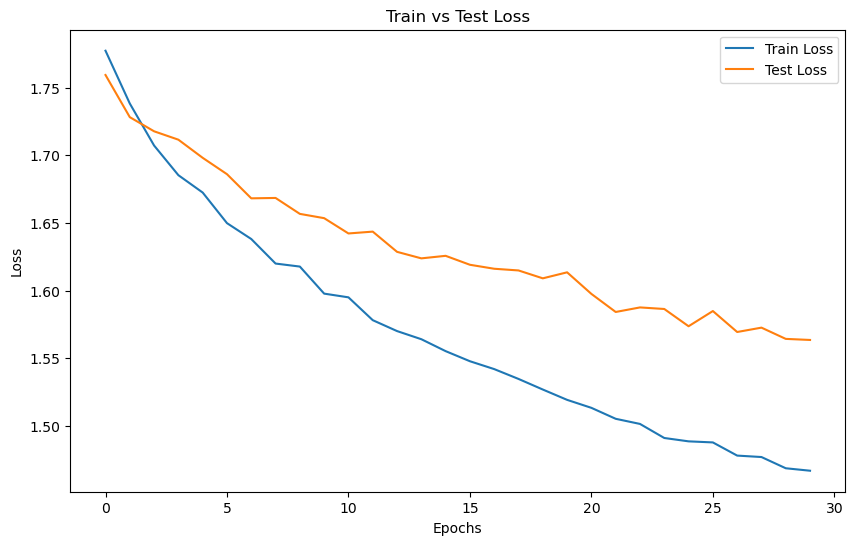

In [ ]:
# import torch

# # Initialize Lists to Store Losses
# train_losses = []
# test_losses = []

# # the Training Loop

# # Assuming use of CPU; if using GPU, replace '.cpu()' with '.cuda()' where necessary
# device = torch.device("cpu")
# model.to(device)

# num_epochs = 30  # Specify the number of epochs

# for epoch in range(num_epochs):
#     model.train()

#     running_loss_train = 0.0
#     for features, labels in train_loader:
#         features, labels = features.to(device), labels.to(device)

#         optimizer.zero_grad()

#         # Directly use the classifier on features if using only the last layer
#         outputs = model.fc(features)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss_train += loss.item()
#     avg_train_loss = running_loss_train / len(train_loader)
#     train_losses.append(avg_train_loss)


#     # Evaluation Phase
#     model.eval()
#     running_loss_test = 0.0
#     with torch.no_grad():
#         for features, labels in test_loader:
#             features, labels = features.to(device), labels.to(device)

#             # Directly use the classifier on features
#             outputs = model.fc(features)
#             loss = criterion(outputs, labels)

#             running_loss_test += loss.item()
#     avg_test_loss = running_loss_test / len(test_loader)
#     test_losses.append(avg_test_loss)

#     print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss}, Test Loss: {avg_test_loss}")


# # Plot Train and Test Losses
# import matplotlib.pyplot as plt

# # Plotting both the training and test losses
# plt.figure(figsize=(10, 6))
# plt.plot(train_losses, label='Train Loss')
# plt.plot(test_losses, label='Test Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Train vs Test Loss')
# plt.legend()
# plt.show()

Step 5.5: Evaluate the Model
After training, evaluate the model on your test dataset to see its performance.

In [ ]:
# model.eval()  # Set model to evaluation mode
# correct = 0
# total = 0
# with torch.no_grad():
#     for features, labels in test_loader:
#         features, labels = features.to(device), labels.to(device)

#         # Directly use the classifier on features
#         outputs = model.fc(features)

#         # Get the predictions from the maximum value
#         _, predicted = torch.max(outputs.data, 1)

#         # Update total and correct predictions
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# # Calculate accuracy
# accuracy = 100 * correct / total
# print(f'Accuracy of the model on the test images: {accuracy}%')


Accuracy of the model on the test images: 35.13513513513514%


Step 5.6: Save the model

In [ ]:
# # Define the path where you want to save the model
# model_save_path = 'second_try_model_snapshots/resnet50_modified_last_fc.pth'

# # Save the model's state_dict
# torch.save(model.state_dict(), model_save_path)

# print(f'Model saved to {model_save_path}')

Model saved to second_try_model_snapshots/resnet50_modified_last_fc.pth
